# Randomized Benchmarking: Interleaved RB


在本笔记本中，我们探索 randomized_benchmarking.py 中与交错随机基准测试 (IRB) 特别相关的方法子集。 我建议首先查看笔记本示例/randomized_benchmarking.ipynb，因为我们将假设熟悉其内容并将 IRB 视为对“标准”RB 协议的修改。

在标准 RB 中，我们感兴趣的是表征噪声对门的平均影响，并且我们估计每个 Clifford 的平均错误率。 Interleaved  RB 旨在表征特定门，该门在整个标准 RB 序列中“交错”。 该协议是标准 RB 的简单扩展，其中涉及运行随机 Clifford 序列，并在每个 Clifford 之后Interleaved 感兴趣的门 G。 具体来说，我们变换一个标准的RB序列
$$C_1, C_2, C_3, \dots , C_{N-1}, C_{\textrm{inverse}}$$
into an 'interleaved' sequence
$$C_1, G, C_2, G, C_3, G, \dots , C_{N-1}, G, C'_{\textrm{inverse}}$$
其中 G 是我们想要表征的门。请注意，我们仍然需要反转序列，因此 G 必须是 Clifford 群的元素，并且必须更新最终的invert gate以 invert 包括 G 在内的整个门序列。


IRB协议可以概括如下：
- 我们想要表征作用于量子位集 Q 的门 G
- 在量子位 Q 上运行标准 RB 并估计 rb 衰减。
- 生成另一组序列，其中门 G 在每个序列中交错。 完全像运行标准 RB 一样运行这些序列并估计 rb 衰减，我们将其称为 irb 衰减。 由于 G 的额外应用的影响，我们预计该参数将小于标准 rb 衰减。
- 使用两个衰减参数来计算门 G 上的误差。我们还可以得到 G 保真度的下限和上限。
- （可选）对量子位 Q 运行幺正性实验，并使用它来提高上一步的保真度范围。
主要参考文献：
1. Magesan, Easwar, et al. “Efficient Measurement of Quantum Gate Error by Interleaved Randomized Benchmarking.” Physical Review Letters, vol. 109, no. 8, Aug. 2012, p. 080505. arXiv.org, https://doi.org/10.1103/PhysRevLett.109.080505.


## IRB code


In [1]:
# Needs in terminal:
# $ quilc -S
# $ qvm -S

import numpy as np

from pyquil.api import BenchmarkConnection, get_qc
from forest.benchmarking.randomized_benchmarking import *
from forest.benchmarking.plotting import plot_figure_for_fit

from pyquil.gates import *
from pyquil import Program


%matplotlib inline

In [2]:
bm = BenchmarkConnection()
qc = get_qc("9q-square-qvm", noisy=True)

### Generate an RB and IRB experiment


这里使用CNOT gate 作为 interleaved gate。

In [3]:
# Choose your gate
qubits = (0, 1)
gate = Program(CNOT(*qubits))

# Choose your parameters
qubit_groups = [qubits]
depths = [2, 15, 25, 30, 60]
num_sequences = 25
depths = [d for d in depths for _ in range(num_sequences)]

rb_expts = generate_rb_experiments(bm, qubit_groups, depths)
# provide the extra arg for the interleaved gate
inter_expts = generate_rb_experiments(bm, qubit_groups, depths, interleaved_gate=gate)

### Run the standard RB experiment


这大约需要一分钟。我们提取估计的衰减参数并绘制结果。


100%|██████████| 125/125 [02:52<00:00,  1.38s/it]
d:\anaconda\envs\quantum-RB\lib\site-packages\lmfit\model.py:2074: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, reduce_complex(self.data),
d:\anaconda\envs\quantum-RB\lib\site-packages\lmfit\model.py:2195: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, residuals,
WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


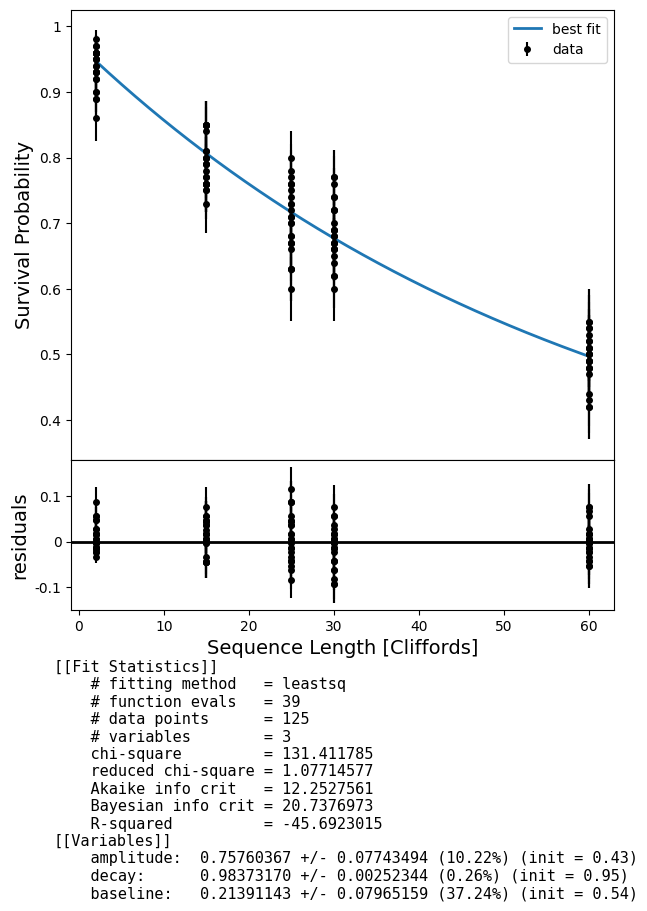

In [4]:
# NBVAL_SKIP
# tag this cell to be skipped during testing

# Run the RB Sequences on a QuantumComputer
num_shots=100
rb_results = acquire_rb_data(qc, rb_expts, num_shots, show_progress_bar=True)

# Calculate a fit to a decay curve
stats = get_stats_by_qubit_group(qubit_groups, rb_results)[qubit_groups[0]]
fit = fit_rb_results(depths, stats['expectation'], stats['std_err'], num_shots)

# Extract rb decay parameter
rb_decay = fit.params['decay'].value
rb_decay_error = fit.params['decay'].stderr

# Plot
fig, axs = plot_figure_for_fit(fit, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability")

### Now run the interleaved RB experiment


这比最后一个单元格花费的时间要长一些。


100%|██████████| 125/125 [03:30<00:00,  1.68s/it]
WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


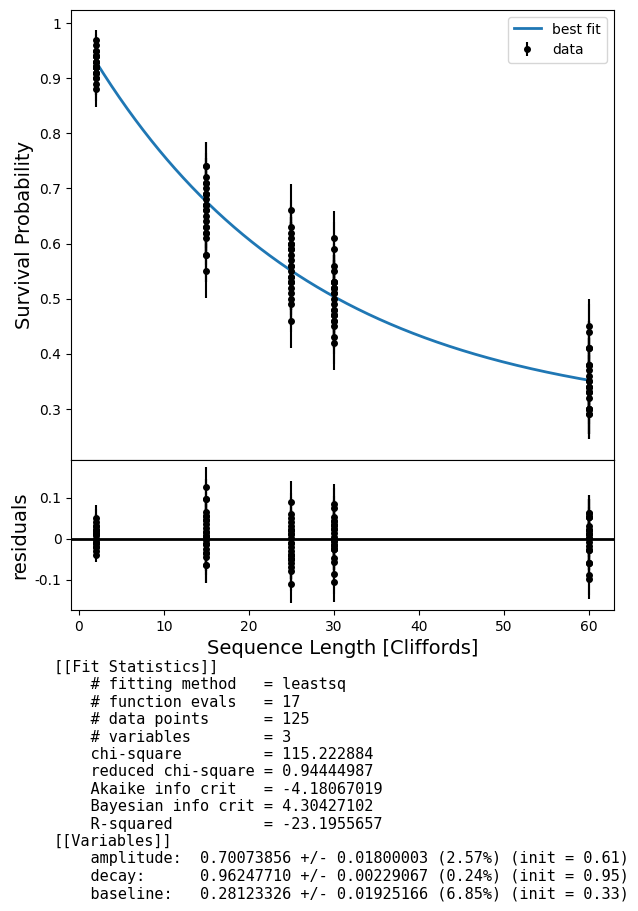

In [5]:
# NBVAL_SKIP
# tag this cell to be skipped during testing

# Run the RB Sequences on a QuantumComputer
num_shots=100
inter_results = acquire_rb_data(qc, inter_expts, num_shots, show_progress_bar=True)

# Calculate a fit to a decay curve
stats = get_stats_by_qubit_group(qubit_groups, inter_results)[qubit_groups[0]]
fit = fit_rb_results(depths, stats['expectation'], stats['std_err'], num_shots)

# Extract irb decay parameter
irb_decay = fit.params['decay'].value
irb_decay_error = fit.params['decay'].stderr

# Plot
fig, axs = plot_figure_for_fit(fit, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability")

由于交错门的额外实例增加了噪声，我们预计 irb_decay 会稍微小一些。


In [6]:
print(rb_decay)
print(irb_decay)

0.9837317035109244
0.9624770967129128


### Extracting gate error and bounds


使用这两个衰减值，我们可以估计所选门的误差。


In [8]:
dim = 2**len(qubits)
print(rb_decay_to_gate_error(rb_decay, dim))
gate_error = irb_decay_to_gate_error(irb_decay, rb_decay, dim)
print(gate_error)

0.01220122236680668
0.01620457594445282


我们还可以使用两个衰减值来确定我们的估计的bounds。


In [9]:
bounds = interleaved_gate_fidelity_bounds(irb_decay, rb_decay, dim)
print(bounds)

[0.9675908481110944, 1.0]


In [10]:
assert(bounds[0] < 1-gate_error and 1-gate_error < bounds[1])

### Improving the bounds with unitarity

为了获得改进的界限，我们可以按照下述论文中中描述的方法运行额外的幺正性实验。 如果单位性 RB 不熟悉，请参阅 Examples/randomized_benchmarking_unitarity.ipynb。这特别慢。

1. Carignan-Dugas, Arnaud, et al. “Bounding the Average Gate Fidelity of Composite Channels Using the Unitarity.” New Journal of Physics, vol. 21, no. 5, May 2019, p. 053016. arXiv.org, https://doi.org/10.1088/1367-2630/ab1800.


In [11]:
# NBVAL_SKIP
# tag this cell to be skipped during testing. It is particularly SLOW, around 6 minutes

num_shots = 50

expts = generate_unitarity_experiments(bm, qubit_groups, depths, num_sequences)

results = acquire_rb_data(qc, expts, num_shots, show_progress_bar=True)
stats = get_stats_by_qubit_group(qubit_groups, results)[qubit_groups[0]]
fit = fit_unitarity_results(depths, stats['expectation'], stats['std_err'])

# plot the raw data, point estimate error bars, and fit
fig, axs = plot_figure_for_fit(fit, xlabel="Sequence Length [Cliffords]", ylabel="Shifted Purity")
unitarity = fit.params['decay'].value

  2%|▏         | 3/125 [00:33<22:22, 11.00s/it]


KeyboardInterrupt: 

希望能够纳入 `unitarity ` 以改善我们的界限。然而，界限可能是 `NaN`，具体取决于 unitarity 的 output 以及 rb 和 irb 衰变之间的差异。对每个参数进行更好的估计有助于防止这种情况发生。


In [ ]:
better_bounds = interleaved_gate_fidelity_bounds(irb_decay, rb_decay, dim, unitarity)
print(better_bounds)